In [28]:
# group columns by meanings
shape_cols = ['Aspect.Ratio','Geodesic.Aspect.Ratio','Circularity','Circularity..Hu.','Elongation','Perimeter']
texture_cols = ['Transparency','Edge.Gradient','Roughness','Sigma.Intensity','Sum.Intensity','Intensity']
size_cols = ['Area..ABD.','Area..Filled.','Diameter..FD.','Diameter..ESD.','Diameter..ABD.','Width','Length','Geodesic.Length']
convexity_cols = ['Convex.Perimeter','Convexity','Compactness']
env_cols_non_numeric = ['lat0','wind','loc', 'lon0', 'site', 'lon1', 'lat1']
env_cols_numeric = ['burbotden', 'avgdepth', 'precip', 'xwaveht', 'mindepth', 'otherfishden', 'cloud_pc', 'maxdepth', 'watert', 'yperchden', 'xangle']
machine_cols = ['gdd2','volbest','trawltime','sam', 'rep', 'repnum', 'fr', 'effspeed']
datetime_cols = ['doy', 'day', 'year', 'month']
file_cols = ['tifffile','csvfile','Image.File','source_file','Time','Timestamp','key','Original.Reference.ID','Date']
image_profile_cols = ['Image.X', 'Image.Y', 'Capture.X', 'Capture.Y', 'Image.File', 'Calibration.Factor', 'Calibration.Image','Camera']

In [13]:
import pandas as pd
final_output = "merged_filtered_zooplankton_data.csv"  # Final merged file
df = pd.read_csv(final_output)
df['Class'] = df['Class'].map({'Calanoid_1':'Calanoid', 'Cyclopoid_1':'Cyclopoid'}) # Clean original class name

In [14]:
# Count missing values per column
missing_values = df.isnull().sum() / df.shape[0]
print(missing_values[missing_values > 0])  # Show only columns with missing values


Biovolume..Cylinder.       0.968085
Biovolume..P..Spheroid.    0.968085
Biovolume..Sphere.         0.968085
distshore                  0.127260
whitefishden               0.016349
unknwcoregonine            0.016349
ciscoden                   0.016349
exposure                   0.028159
smeltden                   1.000000
dtype: float64


Based on the meaning of these columns, those are not significant. Igonre these in the analysis. 


In [15]:
missing_cols = missing_values[missing_values > 0].index
cols_interested = list(set(df.columns).difference(set(missing_cols)))
df = df[cols_interested]

In [16]:
df.shape

(394263, 91)

# Random forest


Classification Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     40529
           1       0.93      0.92      0.93     38324

    accuracy                           0.93     78853
   macro avg       0.93      0.93      0.93     78853
weighted avg       0.93      0.93      0.93     78853


Confusion Matrix:
[[37943  2586]
 [ 2924 35400]]

F1 Score:
0.9277945223430742

ROC curve:


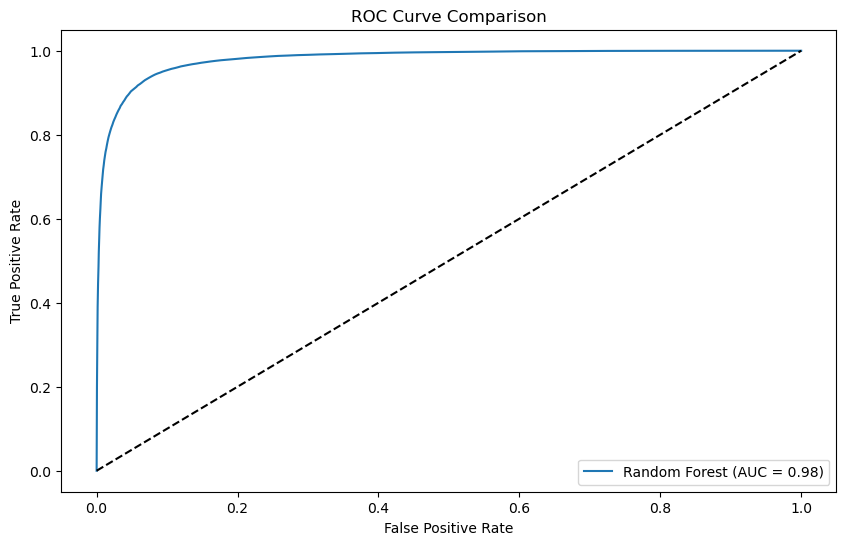

In [41]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

non_numeric_cols = env_cols_non_numeric + env_cols_numeric +machine_cols+datetime_cols+file_cols+['Class']
df_features = df.drop(columns=non_numeric_cols, errors="ignore")
# Define target variable
# y = df["Class"]  # Ensure "Class" represents Calanoid vs. Cyclopoid
y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  # n_jobs=-1 uses all CPU cores
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nROC curve:")
rf_probs = clf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

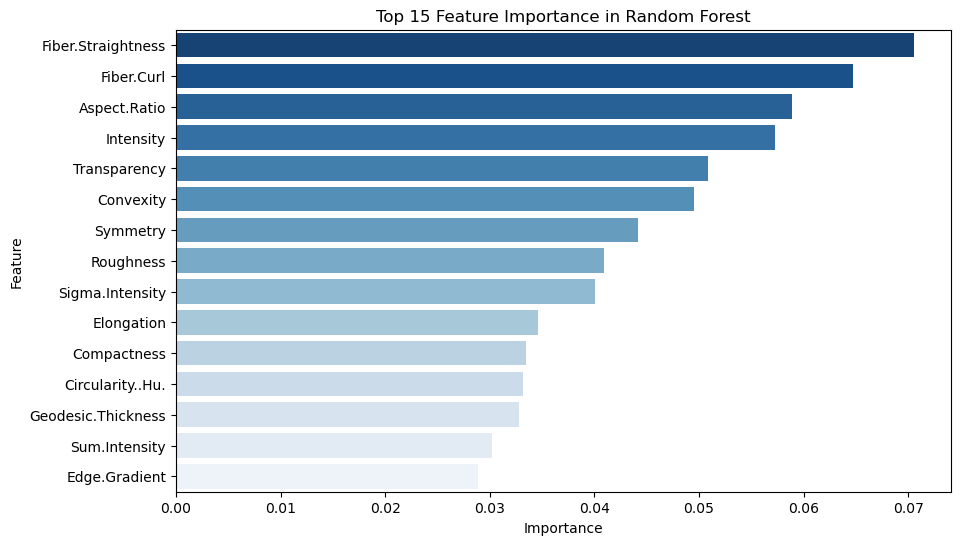

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": clf.feature_importances_
})

# Sort and plot top 15 features
feature_importance = feature_importance.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="Blues_r")
plt.title("Top 15 Feature Importance in Random Forest")
plt.show()

# XGBoost

/Users/christinaflz/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:09:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

    Calanoid       0.93      0.93      0.93     40529
   Cyclopoid       0.93      0.93      0.93     38324

    accuracy                           0.93     78853
   macro avg       0.93      0.93      0.93     78853
weighted avg       0.93      0.93      0.93     78853


Confusion Matrix:
[[37676  2853]
 [ 2683 35641]]

F1 Score:
0.9279335572391887

ROC curve:


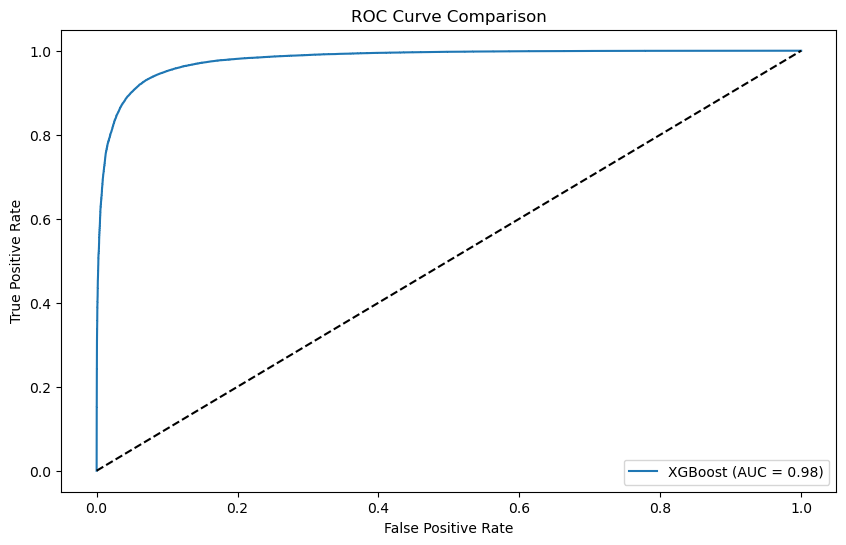

In [44]:
from xgboost import XGBClassifier

non_numeric_cols = env_cols_non_numeric + env_cols_numeric + machine_cols + datetime_cols + file_cols + image_profile_cols + ['Class']
df_features = df.drop(columns=non_numeric_cols, errors="ignore")

y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=2453,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Calanoid', 'Cyclopoid']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nROC curve:")
xgb_probs = model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


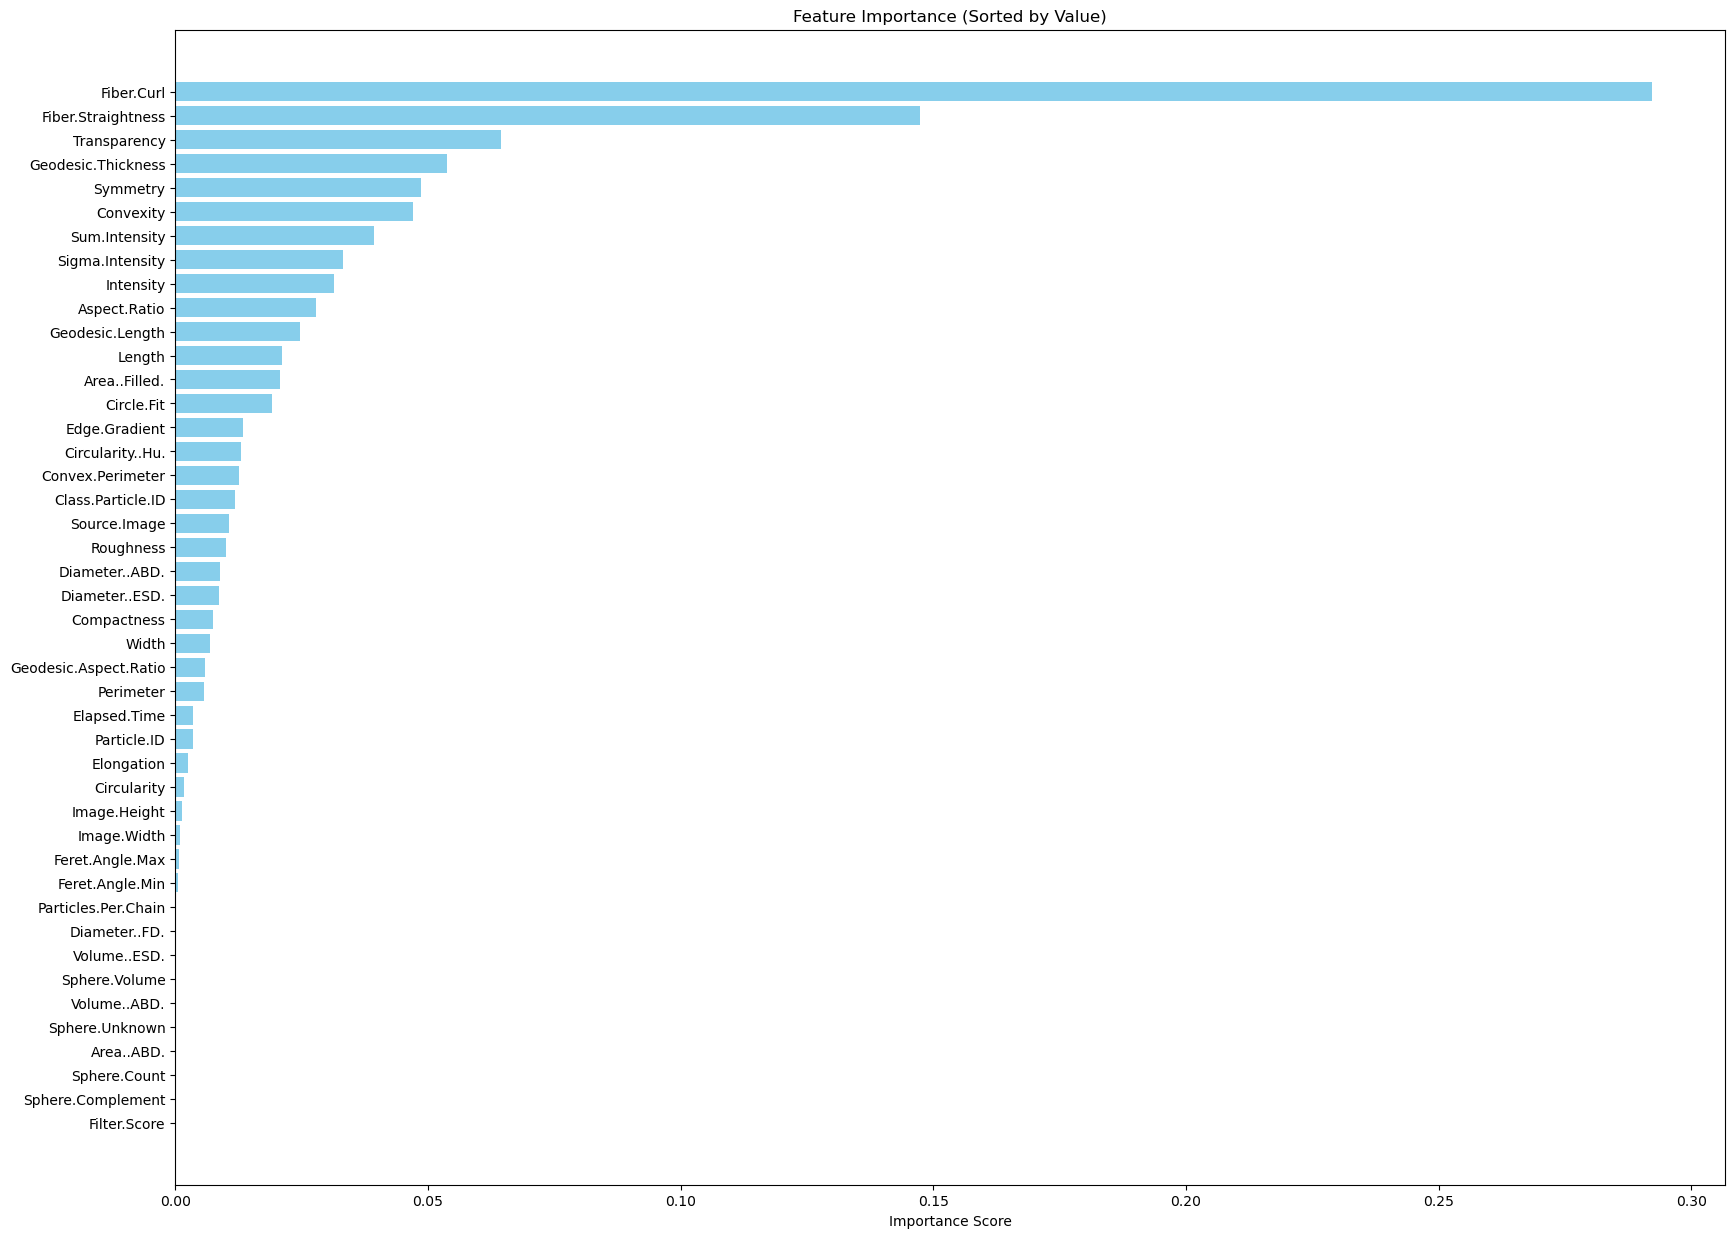

In [45]:
# Feature importance
import matplotlib.pyplot as plt

importance = model.feature_importances_
feature_names = df_features.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot sorted feature importance
plt.figure(figsize=(20, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance (Sorted by Value)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()